## Import packages

In [4]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi_edit as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [5]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [6]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [7]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params.py'>

In [8]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [9]:
lower = np.array([0.1125, 0.65])
upper = np.array([0.1275, 0.85])
prior = priors.Uniform(lower, upper)

In [10]:
theta_fiducial = np.array([0.1197, 0.76])

In [11]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)
N_counts = N_countsSimulator.N_counts
#N_counts = N_countsSimulator.simulation(theta_fiducial, 1)
N_counts

array([2.01375933e+04, 6.15932449e+04, 7.92155533e+04, 7.05138175e+04,
       5.00615557e+04, 2.66747919e+03, 6.24078572e+03, 5.83486556e+03,
       3.60888575e+03, 1.70548356e+03, 1.21730998e+02, 1.76398359e+02,
       9.32196154e+01, 2.99497101e+01, 6.76248388e+00])

In [12]:
N_counts.astype(int)

array([20137, 61593, 79215, 70513, 50061,  2667,  6240,  5834,  3608,
        1705,   121,   176,    93,    29,     6])

## Version 2

(1) Compute fiducial number of counts N for different redshift bins (for a range of masses, 14 to 15.5)

(2) Draw N samples from joint redshift-mass distribution

(3) Create mock catalogue

In [13]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins as n_counts_simulator_2

In [14]:
importlib.reload(n_counts_simulator_2)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_og_bins.py'>

In [15]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [16]:
N_countsSimulator2 = n_counts_simulator_2.Model(log10masses, z_min, z_max)

In [17]:
N_countsSimulator2.N_counts[0]

array([22926.84511865, 68010.58076614, 85143.87570284, 74152.91292208,
       51774.03079771])

In [18]:
t1 = time.process_time()
mock_pairs = N_countsSimulator2.simulation(theta_fiducial, 1)
t2 = time.process_time()
print('time per 1 sim: '+ str(t2-t1))

time per 1 sim: 11.890695609


In [19]:
mock_pairs 

array([20049, 61363, 78981, 70300, 49997,  2752,  6467,  6071,  3829,
        1770,   126,   181,    92,    24,     7])

In [20]:
N_counts.astype(int)

array([20137, 61593, 79215, 70513, 50061,  2667,  6240,  5834,  3608,
        1705,   121,   176,    93,    29,     6])

### DEBUGGING

### (1) Compare 2D probability distribution with 2D histogram of cluster number counts

In [36]:
def get_probability_dist(cosmo_ccl, seed, N, z_min, z_max, M_min, M_max, n_grid_z= 1000, n_grid_M = 10000):
    z_array = np.linspace(z_min, z_max, num = n_grid_z)
    masses = np.logspace(M_min, M_max, num =  n_grid_M)
    z_array_flat = np.repeat(z_array.reshape(len(z_array), 1), len(masses), axis = 1).flatten()
    masses_flat = np.repeat(masses.reshape(1, len(masses)), len(z_array), axis = 0).flatten()
        
    mass_funct = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl)
    hmf = N_countsSimulator2.halo_mass_function2(mass_funct, cosmo_ccl, masses, z_array)
    hmf_sums = hmf.sum(axis = 1, keepdims= True)
    prob_norm_M_z = hmf/hmf_sums
        
    prob_z = np.ones(len(z_array))
    prob_z = (prob_z/np.sum(prob_z)).reshape(len(z_array), 1)
    prob_z = np.repeat(prob_z, len(masses), axis = 1)
        
    prob_norm_Mz = prob_norm_M_z*prob_z
    prob_norm_Mz = prob_norm_Mz/np.sum(prob_norm_Mz)
    prob_norm_Mz_flat = prob_norm_Mz.flatten()
        
    indices_array = np.arange(len(prob_norm_Mz_flat))
    indices_values = np.random.choice(indices_array, size = N, p = prob_norm_Mz_flat)#, replace = False)
        
    masses_vals = np.take(masses_flat, indices_values)
    z_vals = np.take(z_array_flat, indices_values)
        
    return prob_norm_Mz, np.stack((masses_vals, z_vals)).T

In [37]:
def get_counts(arr_m):
    count_1 = len(arr_m[(arr_m >= 10**(14.0)) & (arr_m <10**(14.5))])
    count_2 = len(arr_m[(arr_m >= 10**(14.5)) & (arr_m <10**(15.0))])
    count_3 = len(arr_m[(arr_m >= 10**(15.0))])
    return np.array([count_1, count_2, count_3])
        

In [38]:
N_counts_by_z = N_countsSimulator2.N_counts[0]
N_counts_by_z = np.round(N_counts_by_z).astype(int)
N_counts_by_z

array([22927, 68011, 85144, 74153, 51774])

In [39]:
N_counts_true, cosmo_ccl = N_countsSimulator2.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)
N_counts_true = np.round(N_counts_true).astype(int)
N_counts_true

array([22927, 68011, 85144, 74153, 51774])

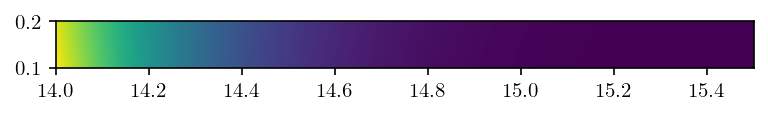

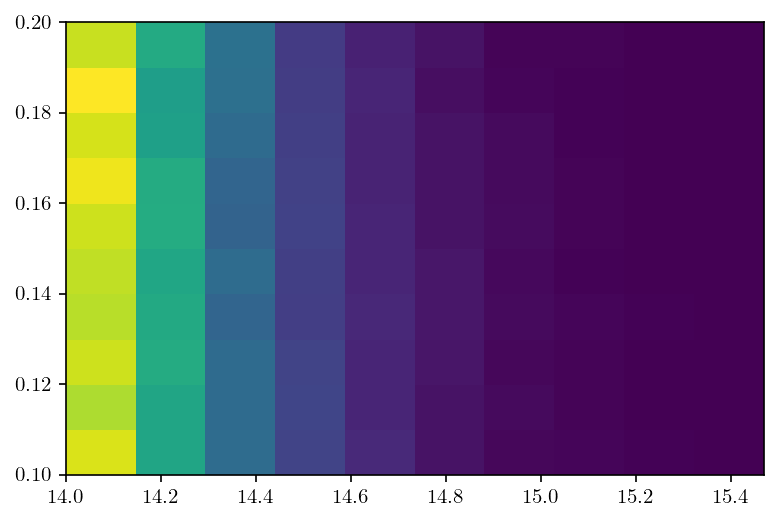

[20039  2750   138]


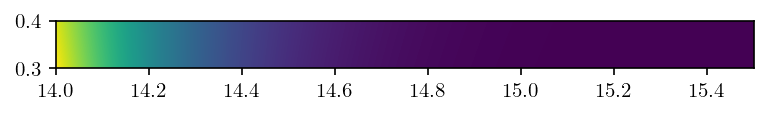

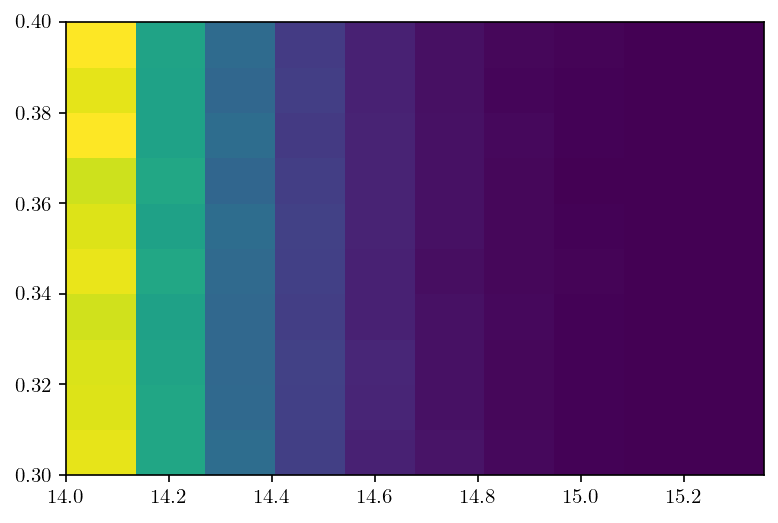

[61593  6254   164]


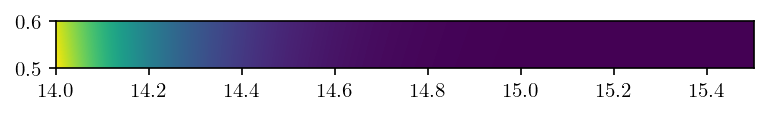

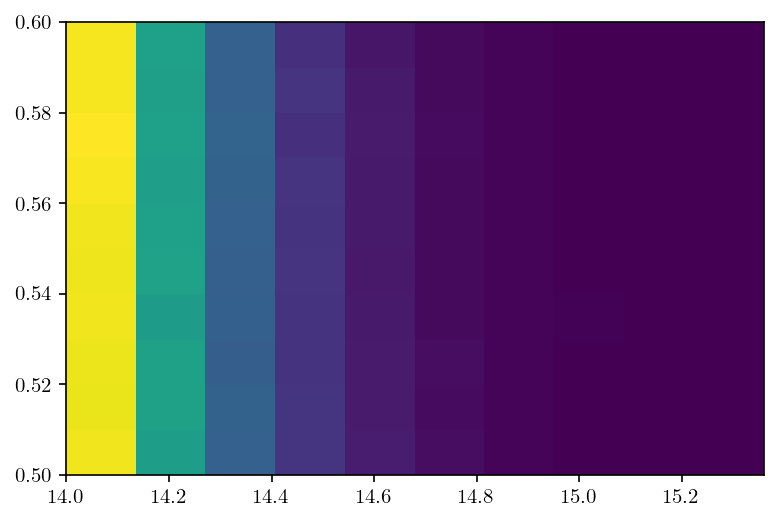

[79204  5854    86]


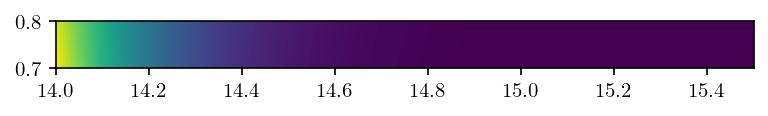

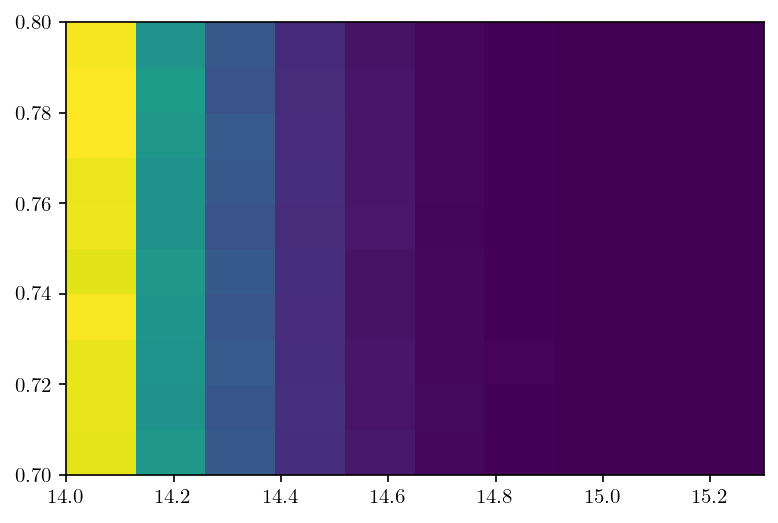

[70505  3617    31]


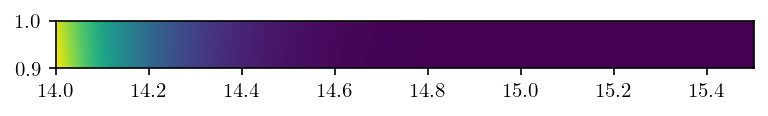

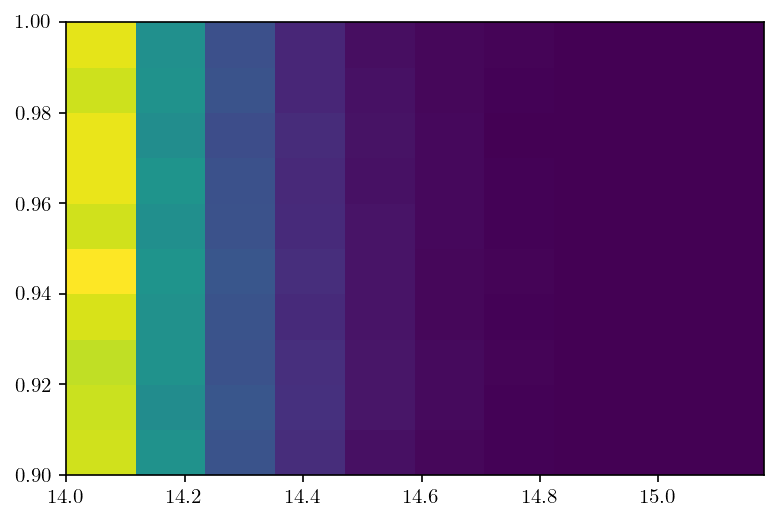

[50111  1650    13]


In [40]:
counts  = []
for i in range(len(N_counts_by_z)):
    prob_norm_Mz, mock_pairs = get_probability_dist(cosmo_ccl, 1, N_counts_by_z[i], z_min[i], z_max[i], log10masses[0], log10masses[-1]) 
    
    fig, ax = plt.subplots()
    im = ax.imshow(prob_norm_Mz,
                   extent=[log10masses[0], log10masses[-1], z_min[i], z_max[i]])

    plt.show()
    
    plt.figure()
    plt.hist2d(np.log10(mock_pairs[:,0]), mock_pairs[:, 1])
    plt.show()
    
    counts_temp = get_counts(mock_pairs[:, 0])
    counts.append(counts_temp)
    print(counts_temp)
    
    

In [43]:
print(N_counts.astype(int).reshape(3, 5).T)
print()
print(np.array(counts))

[[20137  2667   121]
 [61593  6240   176]
 [79215  5834    93]
 [70513  3608    29]
 [50061  1705     6]]

[[20039  2750   138]
 [61593  6254   164]
 [79204  5854    86]
 [70505  3617    31]
 [50111  1650    13]]


### (2) Compare resulting counts for different values of parameters

In [65]:
log10masses = np.linspace(14, 15.5, num = 4)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [66]:
theta_omega_cdm = np.linspace(0.118, 0.122, num = 5)
theta_sigma8 = np.linspace(0.757, 0.762, num = 6)

In [67]:
N_countsArray = []
for i in range(len(theta_omega_cdm)):
    for j in range(len(theta_sigma8)):
        n1 = np.array(N_countsSimulator.all_n_counts_trapz(z_min, z_max, log10masses_2d, np.array([theta_omega_cdm[i], theta_sigma8[j]])))
        N_countsArray.append(n1)

In [68]:
N_countsArray = np.array(N_countsArray)

In [47]:
N_countsArray2 = []
for i in range(len(theta_omega_cdm)):
    for j in range(len(theta_sigma8)):
        theta_temp = np.array([theta_omega_cdm[i], theta_sigma8[j]])
        n1 = np.array(N_countsSimulator2.simulation(theta_temp, 1))
        N_countsArray2.append(n1)

In [48]:
N_countsArray2 = np.array(N_countsArray2)

In [69]:
N_countsArray_ratio = (N_countsArray2/N_countsArray)
N_countsArray_delta = (N_countsArray2 - N_countsArray)

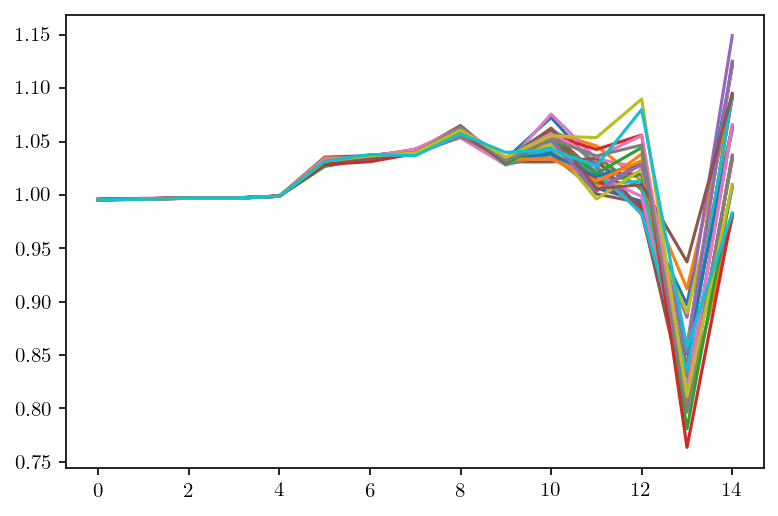

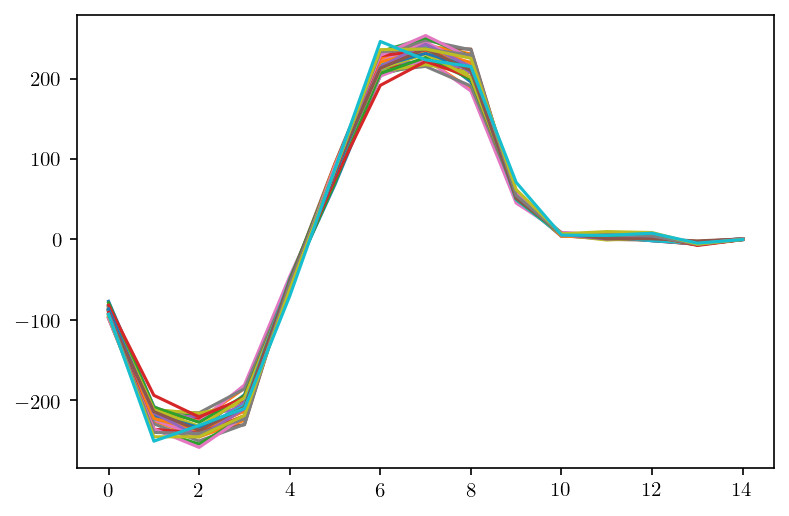

In [70]:
plt.figure(1)
for i in range(N_countsArray_ratio.shape[0]):
    plt.plot(N_countsArray_ratio[i, :])
    
plt.figure(2)
for i in range(N_countsArray_delta.shape[0]):
    plt.plot(N_countsArray_delta[i, :])

### (3) Break M-z bins into smaller bins

In [71]:
N_counts_by_z

array([22927, 68011, 85144, 74153, 51774])

In [162]:
log10masses_temp = np.linspace(14, 15.5, num = 2)
log10masses_2d_temp = np.stack((log10masses_temp[:-1], log10masses_temp[1:]))


In [156]:
def get_mock_pairs(cosmo_ccl, N, z_min, z_max, M_min, M_max, n_grid_z= 1000, n_grid_M = 1000):
    z_array = np.linspace(z_min, z_max, num = n_grid_z)
    masses = np.logspace(M_min, M_max, num =  n_grid_M)
    z_array_flat = np.repeat(z_array.reshape(len(z_array), 1), len(masses), axis = 1).flatten()
    masses_flat = np.repeat(masses.reshape(1, len(masses)), len(z_array), axis = 0).flatten()
        
    mass_funct = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl)
    hmf = N_countsSimulator2.halo_mass_function2(mass_funct, cosmo_ccl, masses, z_array)
    hmf_sums = hmf.sum(axis = 1, keepdims= True)
    prob_norm_M_z = hmf/hmf_sums
        
    prob_z = np.ones(len(z_array))
    prob_z = (prob_z/np.sum(prob_z)).reshape(len(z_array), 1)
    prob_z = np.repeat(prob_z, len(masses), axis = 1)
        
    prob_norm_Mz = prob_norm_M_z*prob_z
    prob_norm_Mz = prob_norm_Mz/np.sum(prob_norm_Mz)
    prob_norm_Mz_flat = prob_norm_Mz.flatten()
        
    indices_array = np.arange(len(prob_norm_Mz_flat))
    indices_values = np.random.choice(indices_array, size = N, p = prob_norm_Mz_flat, replace = False)
        
    masses_vals = np.take(masses_flat, indices_values)
    z_vals = np.take(z_array_flat, indices_values)
        
    return np.stack((masses_vals, z_vals)).T

In [157]:
def get_counts_small_z_bins(z_min, z_max):
    z_min_temp = np.linspace(z_min, z_max, num = 5)
    n_temp = np.round(N_countsSimulator2.all_n_counts_trapz(z_min_temp[:-1], z_min_temp[1:], log10masses_2d_temp, theta_fiducial)[0]).astype(int)
    
    return z_min_temp, n_temp

In [158]:
def get_Mz_array(z_min, z_max, cosmo_ccl):
    z_min_temp, n_temp = get_counts_small_z_bins(z_min, z_max)
    
    mz_pairs = [get_mock_pairs(cosmo_ccl, n_temp[i], z_min_temp[i], z_min_temp[i+1], 14.0, 15.5) for i in range(len(n_temp))]
    return np.concatenate(mz_pairs)

In [159]:
def get_counts(arr_m):
    count_1 = len(arr_m[(arr_m >= 10**(14.0)) & (arr_m <10**(14.5))])
    count_2 = len(arr_m[(arr_m >= 10**(14.5)) & (arr_m <10**(15.0))])
    count_3 = len(arr_m[(arr_m >= 10**(15.0))])
    return np.array([count_1, count_2, count_3])

In [160]:
t1 = time.process_time()
results = [get_Mz_array(z_min[i], z_max[i], cosmo_ccl) for i in np.arange(len(z_min))]
results_bins = [get_counts(results[i][:, 0]) for i in np.arange(len(results))]

t2 = time.process_time()
print(str(t2 - t1) + ' s')
np.array(results_bins).T.flatten()

7.9155600020000065 s


array([20126, 61358, 78989, 70284, 50089,  2682,  6469,  6060,  3835,
        1677,   118,   185,    95,    33,     8])

In [128]:
np.round(N_countsSimulator.N_counts).astype(int)

array([20138, 61593, 79216, 70514, 50062,  2667,  6241,  5835,  3609,
        1705,   122,   176,    93,    30,     7])

In [173]:
import simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_small_z_bins as n_counts_simulator_3

In [189]:
importlib.reload(n_counts_simulator_3)

<module 'simulators.mass_function_n_counts.simulator_trapz_tinker_2params_mock_catalogue_v2_small_z_bins' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_tinker_2params_mock_catalogue_v2_small_z_bins.py'>

In [190]:
log10masses = np.linspace(14, 15.5, num = 2)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [191]:
N_countsSimulator_2 = n_counts_simulator_3.Model(log10masses, z_min, z_max)

In [192]:
N_countsSimulator_2.N_counts

(array([22926.84511865, 68010.58076614, 85143.87570284, 74152.91292208,
        51774.03079771]),
 pyccl.Cosmology(Omega_c=0.25141776937618154, Omega_b=0.04667086746481833, h=0.69, n_s=0.9655, sigma8=0.76, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict'))

In [193]:
t1 = time.process_time()
N_countsSimulator_2.simulation(theta_fiducial, 1)
t2 = time.process_time()
print(str(t2 - t1) + ' s')

7.872640378999904 s


In [194]:
N_countsSimulator_2.simulation(theta_fiducial, 1)


array([20049, 61265, 79051, 70417, 49994,  2752,  6563,  6016,  3700,
        1770,   125,   184,    77,    35,    10])

### (4) Compute hmf only for unique values of z

In [22]:
def get_probability_dist(cosmo_ccl, seed, N, z_min, z_max, M_min, M_max, n_grid_z= 1000, n_grid_M = 10000):
    z_array = np.linspace(z_min, z_max, num = n_grid_z)
    masses = np.logspace(M_min, M_max, num =  n_grid_M)
    z_array_flat = np.repeat(z_array.reshape(len(z_array), 1), len(masses), axis = 1).flatten()
    masses_flat = np.repeat(masses.reshape(1, len(masses)), len(z_array), axis = 0).flatten()
        
    mass_funct = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl)
    hmf = N_countsSimulator2.halo_mass_function2(mass_funct, cosmo_ccl, masses, z_array)
    hmf_sums = hmf.sum(axis = 1, keepdims= True)
    prob_norm_M_z = hmf/hmf_sums
        
    prob_z = np.ones(len(z_array))
    prob_z = (prob_z/np.sum(prob_z)).reshape(len(z_array), 1)
    prob_z = np.repeat(prob_z, len(masses), axis = 1)
        
    prob_norm_Mz = prob_norm_M_z*prob_z
    prob_norm_Mz = prob_norm_Mz/np.sum(prob_norm_Mz)
    prob_norm_Mz_flat = prob_norm_Mz.flatten()
        
    #indices_array = np.arange(len(prob_norm_Mz_flat))
    #indices_values = np.random.choice(indices_array, size = N, p = prob_norm_Mz_flat)#, replace = False)
        
    #masses_vals = np.take(masses_flat, indices_values)
    #z_vals = np.take(z_array_flat, indices_values)
        
    return prob_norm_Mz #, np.stack((masses_vals, z_vals)).T

In [23]:
def get_counts(arr_m):
    count_1 = len(arr_m[(arr_m >= 10**(14.0)) & (arr_m <10**(14.5))])
    count_2 = len(arr_m[(arr_m >= 10**(14.5)) & (arr_m <10**(15.0))])
    count_3 = len(arr_m[(arr_m >= 10**(15.0))])
    return np.array([count_1, count_2, count_3])
        

In [33]:
def get_Mz_array(cosmo_ccl, N, z_min, z_max, M_min, M_max, n_grid_z= 1000, n_grid_M = 5000):
    #np.random.seed(seed) 
        
    z_array = np.linspace(z_min, z_max, num = n_grid_z)
    z_vals = np.random.choice(z_array, size = N)
        
    z_vals_unique, z_vals_counts = np.unique(z_vals, return_counts=True)
        
    masses = np.logspace(M_min, M_max, num =  n_grid_M)
    hmf = N_countsSimulator2.halo_mass_function(cosmo_ccl, masses, z_vals_unique)
    hmf_sums = hmf.sum(axis = 1, keepdims= True)
    prob_norm = hmf/hmf_sums
        
    M_vals = []
    M_vals = [get_M_vals(masses, prob_norm[i,:], size) for i, size in enumerate(z_vals_counts)]
    M_arr = np.concatenate(M_vals)
        
    z_vals_sorted = np.sort(z_vals)
        
    merged_list = tuple(zip(M_arr, z_vals_sorted)) 
        
    return np.array(merged_list)

In [26]:
def get_M_vals(masses, hmf_norm, size):
    M_values = np.random.choice(masses, size = size, p = hmf_norm, replace = False)
    return M_values

In [24]:
N_counts_by_z = N_countsSimulator2.N_counts[0]
N_counts_by_z = np.round(N_counts_by_z).astype(int)
N_counts_by_z

array([22927, 68011, 85144, 74153, 51774])

In [29]:
N_counts_true, cosmo_ccl = N_countsSimulator2.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)
N_counts_true = np.round(N_counts_true).astype(int)
N_counts_true

array([22927, 68011, 85144, 74153, 51774])

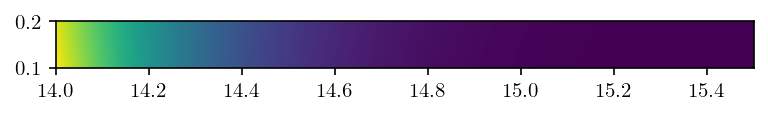

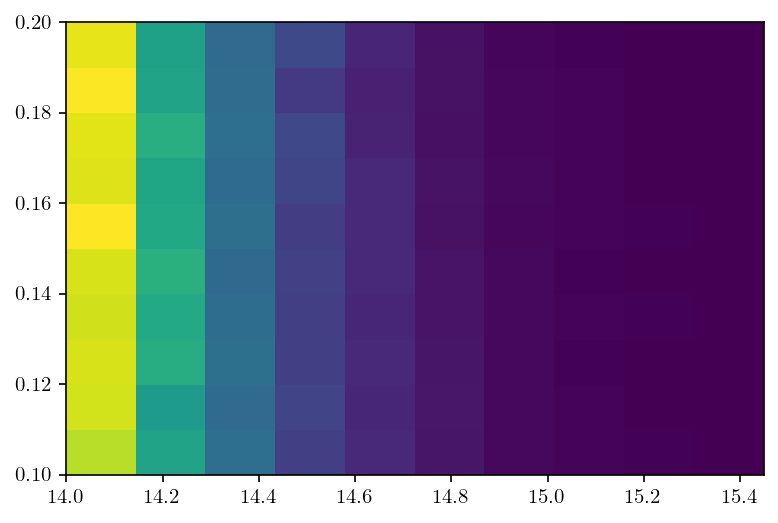

[20104  2699   124]


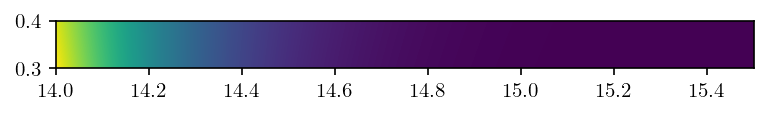

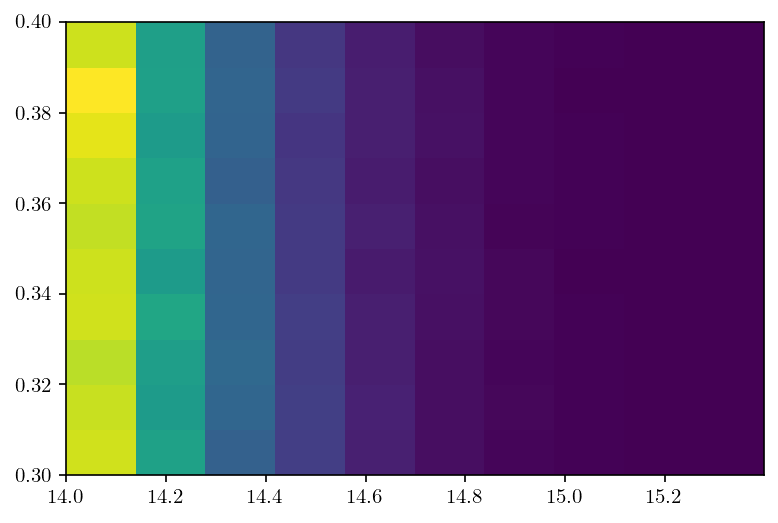

[61517  6304   190]


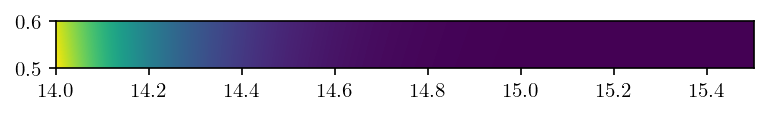

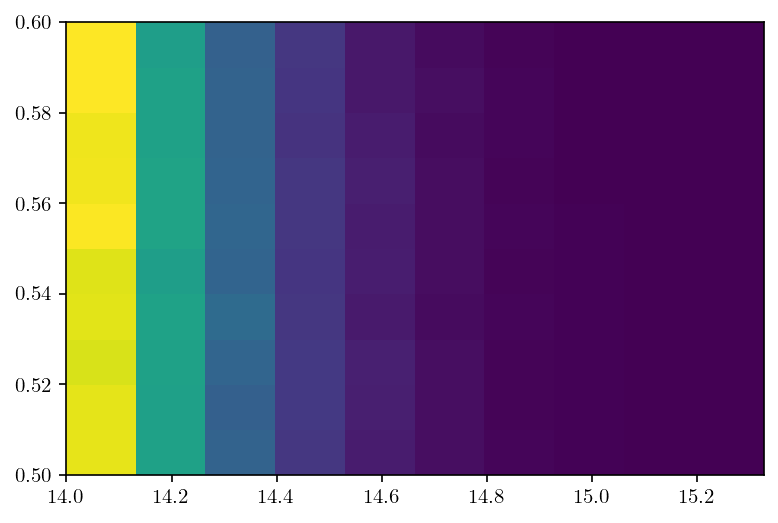

[79015  6036    93]


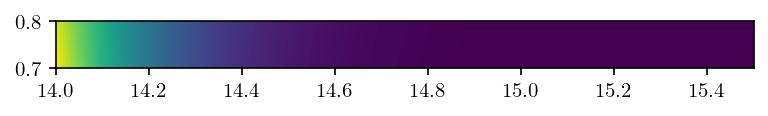

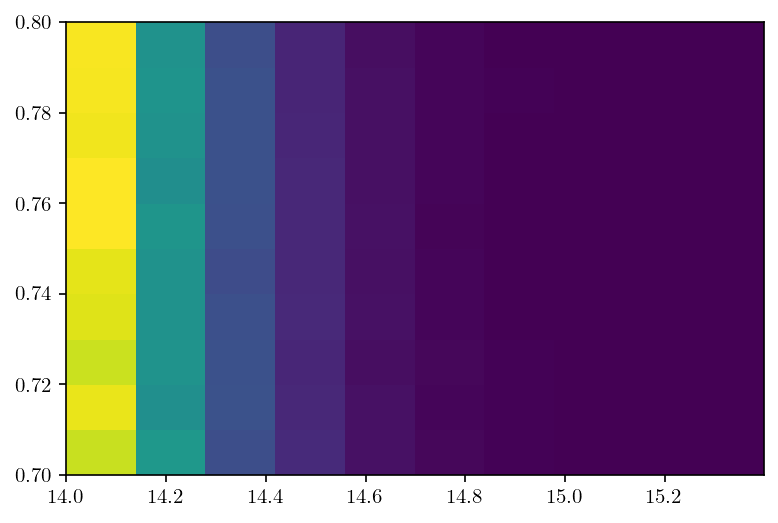

[70356  3756    41]


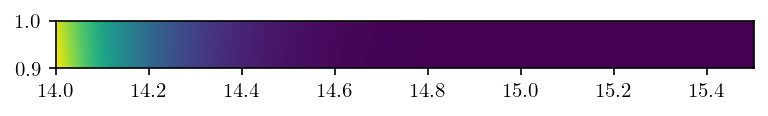

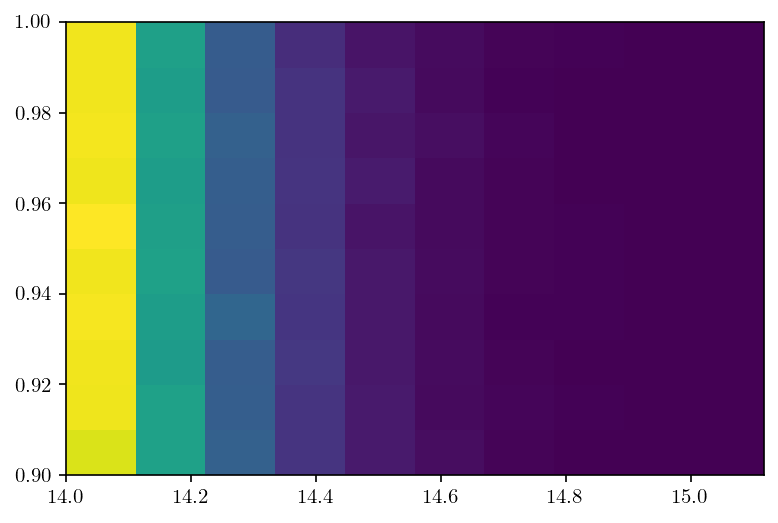

[50046  1718    10]


In [39]:
counts  = []
for i in range(len(N_counts_by_z)):
    prob_norm_Mz = get_probability_dist(cosmo_ccl, 1, N_counts_by_z[i], z_min[i], z_max[i], log10masses[0], log10masses[-1]) 
    
    mock_pairs = get_Mz_array(cosmo_ccl, N_counts_by_z[i], z_min[i], z_max[i], log10masses[0], log10masses[-1], n_grid_z= 1000, n_grid_M = 5000)
    
    fig, ax = plt.subplots()
    im = ax.imshow(prob_norm_Mz,
                   extent=[log10masses[0], log10masses[-1], z_min[i], z_max[i]])

    plt.show()
    
    plt.figure()
    plt.hist2d(np.log10(mock_pairs[:,0]), mock_pairs[:, 1])
    plt.show()
    
    counts_temp = get_counts(mock_pairs[:, 0])
    counts.append(counts_temp)
    print(counts_temp)

In [37]:
get_Mz_array(cosmo_ccl, N_counts_by_z[0], z_min[0], z_max[0], log10masses[0], log10masses[-1], 
             n_grid_z= 1000, n_grid_M = 5000)

array([[2.47388026e+14, 1.00000000e-01],
       [7.73530951e+14, 1.00000000e-01],
       [1.52102526e+14, 1.00000000e-01],
       ...,
       [1.60635366e+14, 2.00000000e-01],
       [1.55933199e+14, 2.00000000e-01],
       [1.92777796e+14, 2.00000000e-01]])

In [41]:
results = [get_Mz_array(cosmo_ccl, N_counts_true[i], z_min[i], z_max[i], log10masses[0], log10masses[-1]) 
                   for i in np.arange(len(N_counts_true))]

In [42]:
np.vstack(results)

array([[5.37831369e+14, 1.00000000e-01],
       [1.09624590e+14, 1.00000000e-01],
       [1.93444912e+14, 1.00000000e-01],
       ...,
       [1.05027798e+14, 1.00000000e+00],
       [1.40776352e+14, 1.00000000e+00],
       [1.07449956e+14, 1.00000000e+00]])

In [47]:
np.array([get_counts(results[i][:, 0]) for i in range(len(results))]).T.flatten()

array([20159, 61371, 78980, 70439, 49984,  2633,  6447,  6074,  3680,
        1779,   135,   193,    90,    34,    11])

In [49]:
N_counts_true, cosmo_ccl = N_countsSimulator2.all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)


In [81]:
def get_bins(seed, N_counts_true, z_min, z_max, log10masses):
    np.random.seed(seed)
    
    N_counts_t = np.random.poisson(N_counts_true) 
    results = [get_Mz_array(cosmo_ccl, N_counts_t[i], z_min[i], z_max[i], log10masses[0], log10masses[-1],
                            n_grid_z= 1000, n_grid_M = 10000) 
                   for i in np.arange(len(N_counts_true))]
    data_vector = np.array([get_counts(results[i][:, 0]) for i in range(len(results))]).T.flatten()
    return data_vector

In [82]:
t1 = time.process_time()
get_bins(i, N_counts_true, z_min, z_max, log10masses)
t2 = time.process_time()
print('time per 1 sim: ' + str(t2 -t1))

time per 1 sim: 9.45182154400004


In [74]:
N_counts_temp = []

for i in range(100):
    N_counts_temp.append(get_bins(i, N_counts_true, z_min, z_max, log10masses))


In [75]:
N_counts_temp = np.array(N_counts_temp)

In [76]:
N_counts_og.shape

(100, 15)

In [77]:
N_counts_og = np.load('N_counts1.npy')

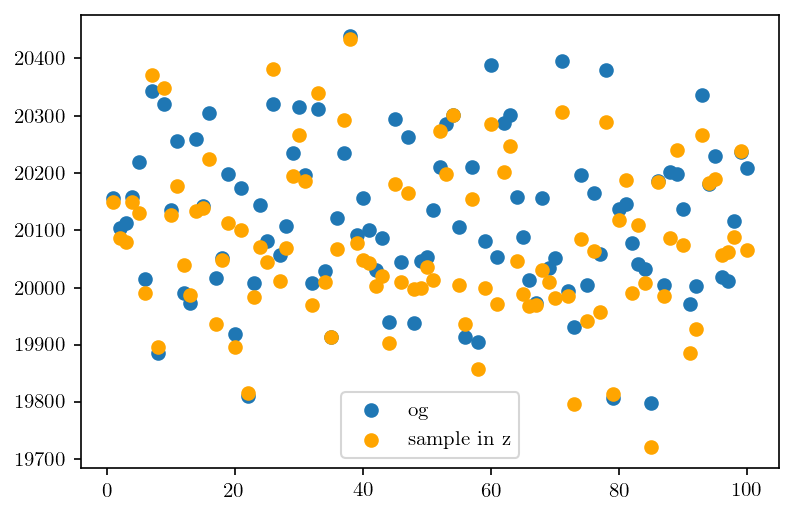

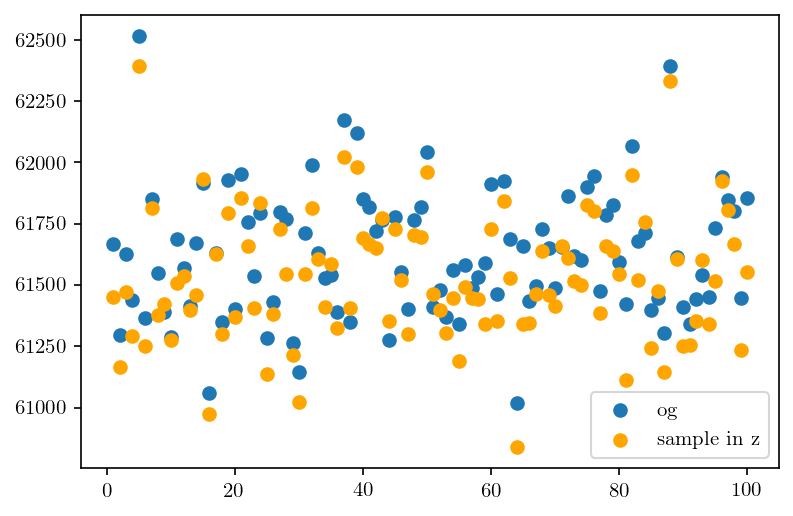

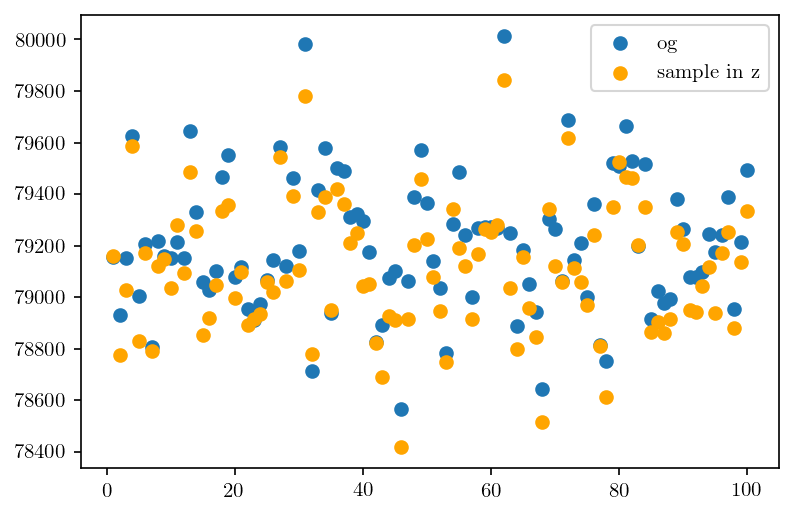

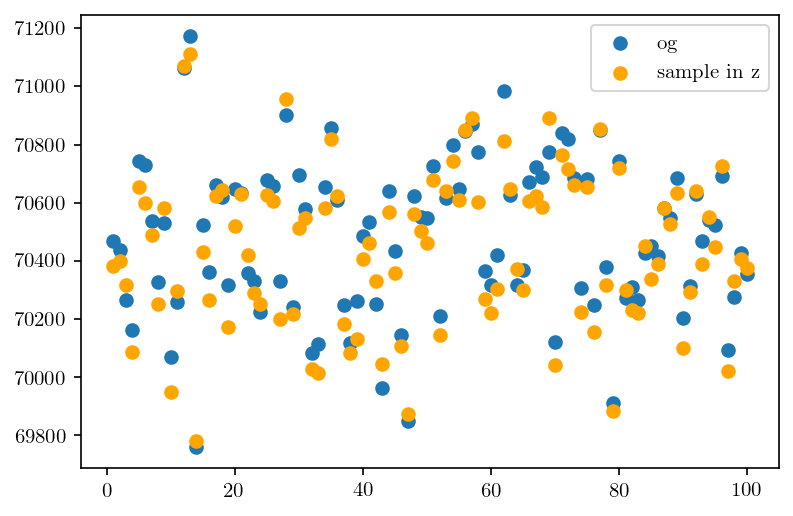

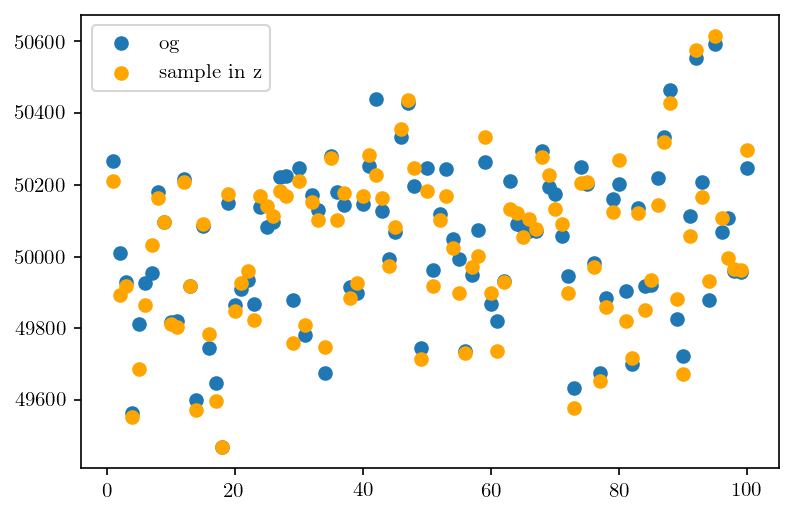

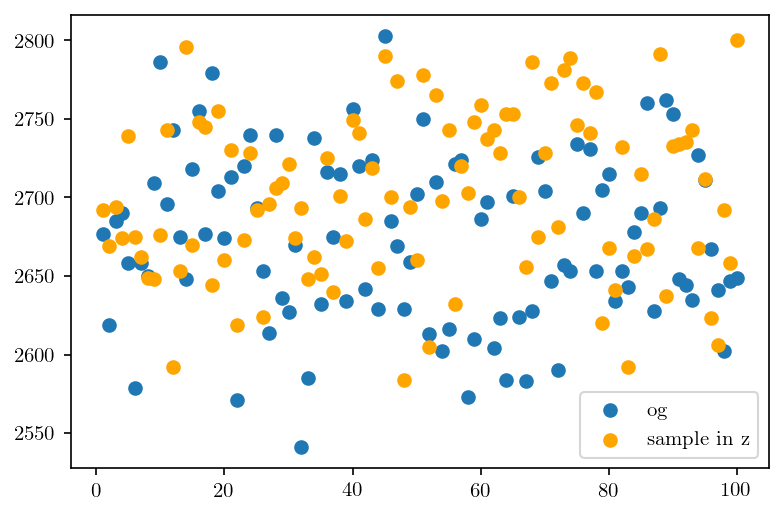

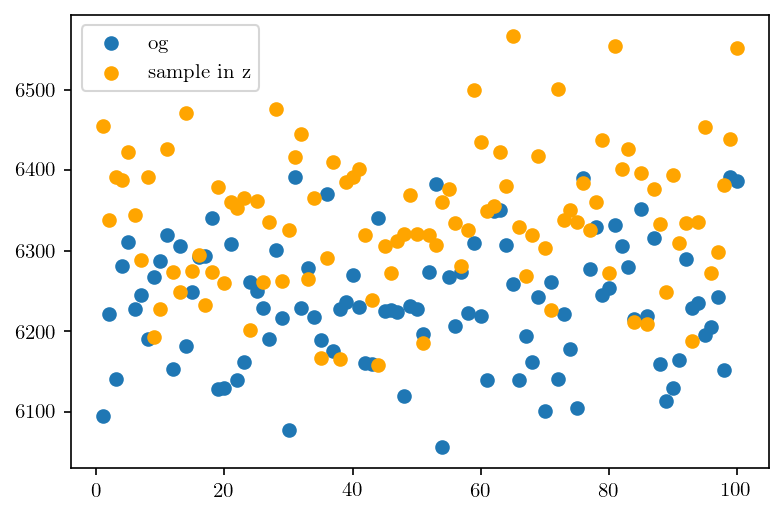

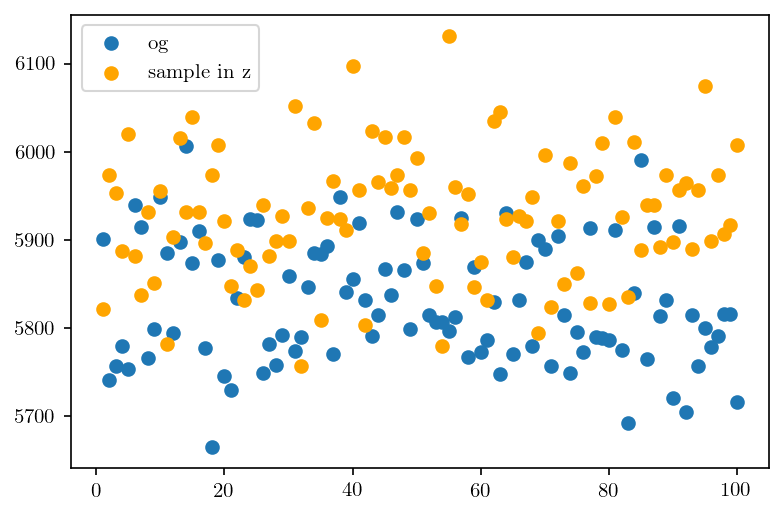

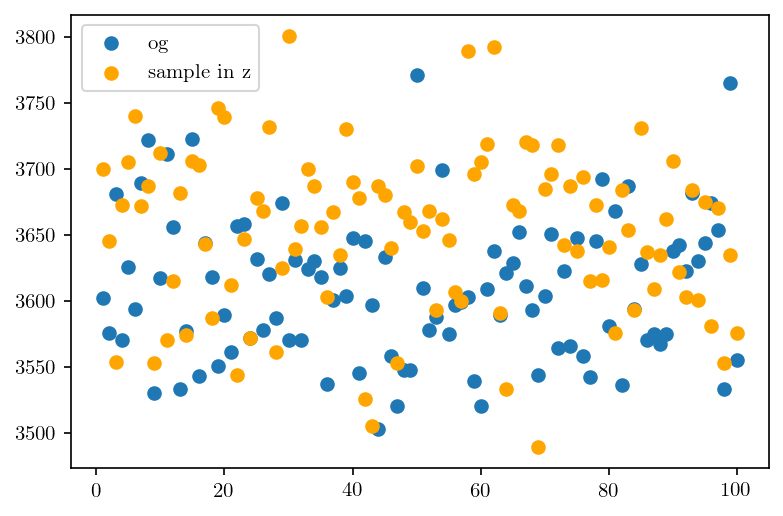

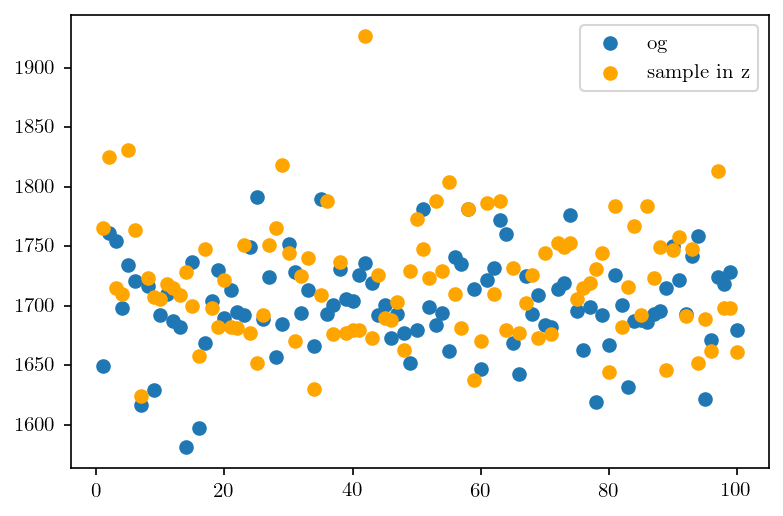

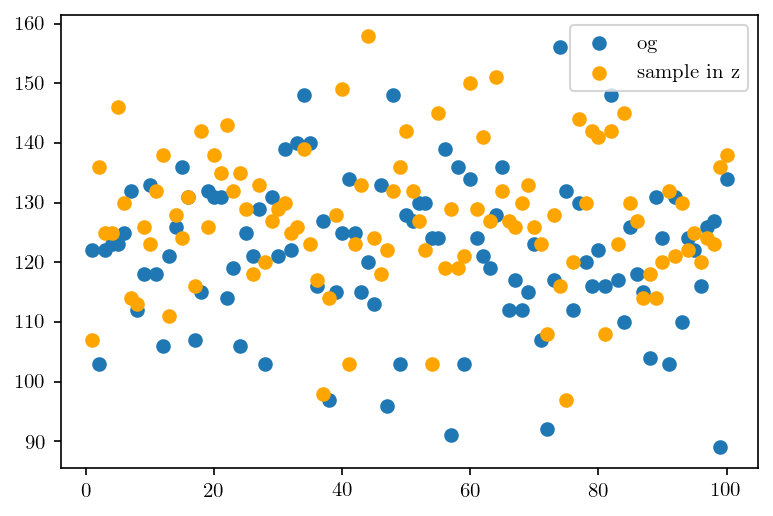

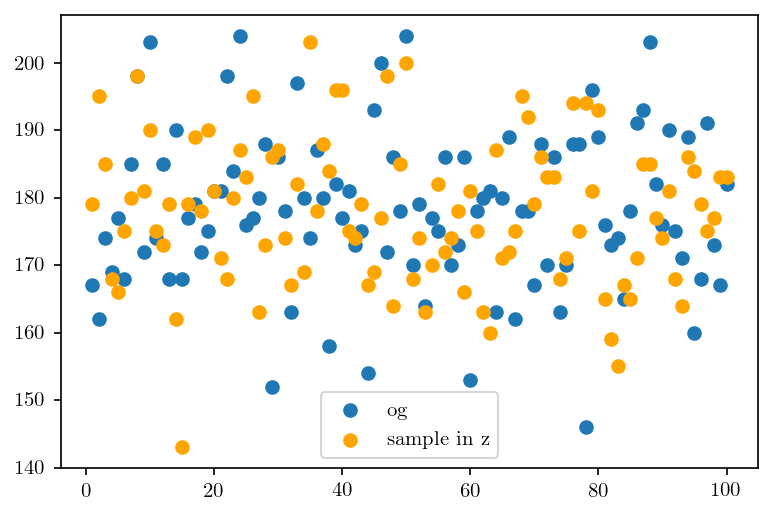

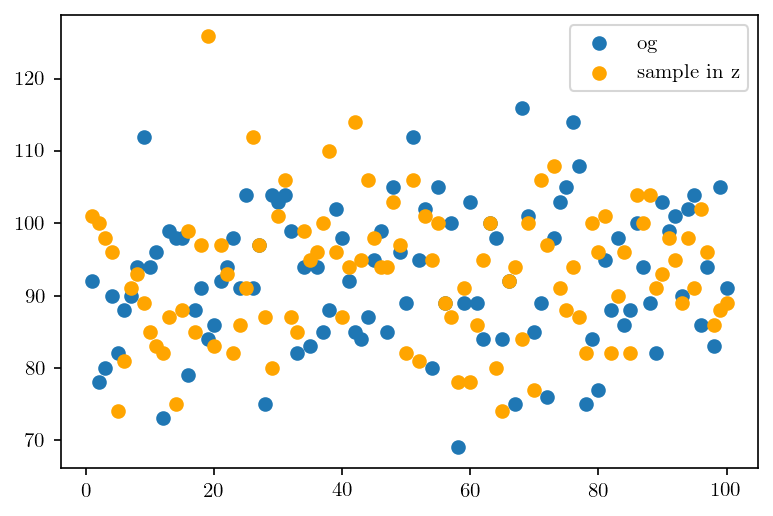

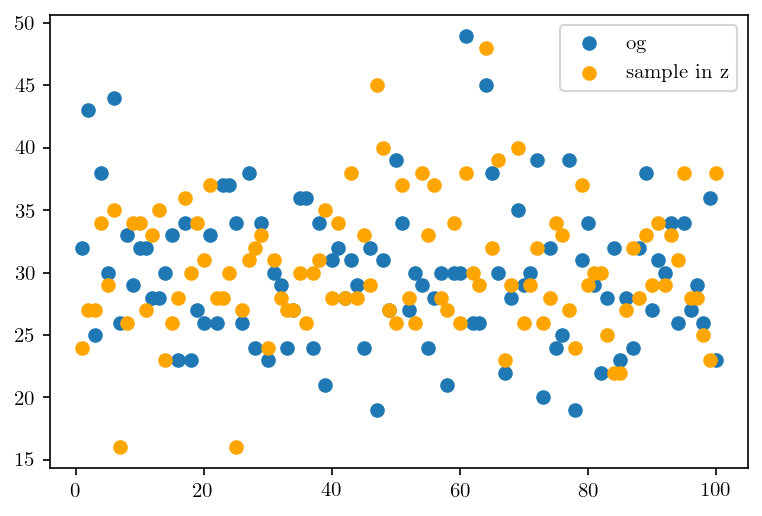

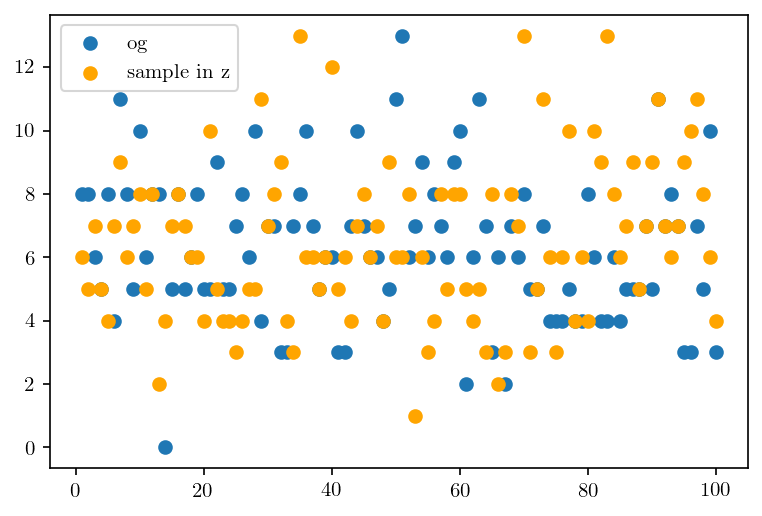

In [78]:
seeds = np.linspace(1, 100, num = 100)
for i in range(N_counts_og.shape[1]):
    plt.figure()
    plt.scatter(seeds, N_counts_og[:, i], label = 'og')
    plt.scatter(seeds, N_counts_temp[:, i], label = 'sample in z', c = 'orange')
    plt.legend(loc = 'best')